In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [20]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [21]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./leapGestRecog/0' + str(i) + '/' + j + '/'): # Loop over the images
                path = './leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

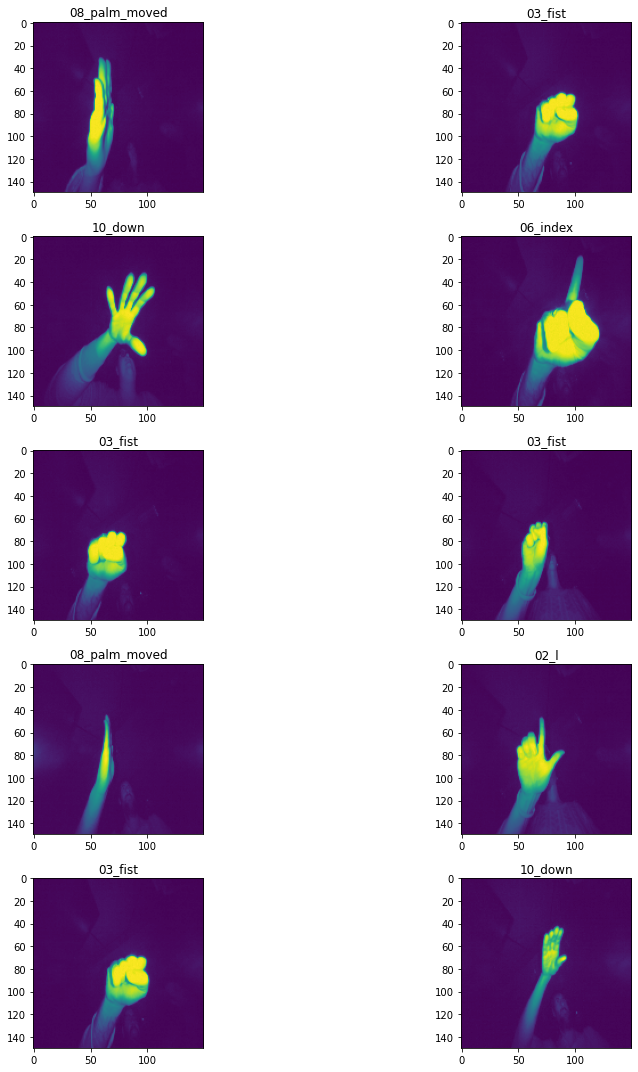

In [22]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [23]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [24]:

TRAIN_RATIO = 0.7
TEST_RATIO = 0.1
VALIDATION_RAIO = 0.2

x_train,x_val,y_train,y_val=train_test_split(x_data,y_data,test_size=(1-TRAIN_RATIO))
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,test_size=((TEST_RATIO/(VALIDATION_RAIO+TEST_RATIO))))

#### Building the Model

In [25]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

batch_size=128
epochs=10

In [26]:
checkpoint = ModelCheckpoint(
    './model/',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq=1
)
earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reducer]

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 96)      

#### Training the model

In [29]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
110/110 [==============================] - 101s 914ms/step - loss: 0.3801 - accuracy: 0.8760 - val_loss: 0.0392 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 102s 927ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0275 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 103s 933ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0070 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - 104s 945ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - 103s 939ms/step - loss: 1.1935e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 6/10
110/110 [==============================] - 106s 965ms/step - loss: 7.1718e-06 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 7/10
110/110 [==================

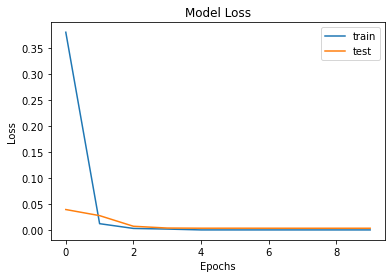

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

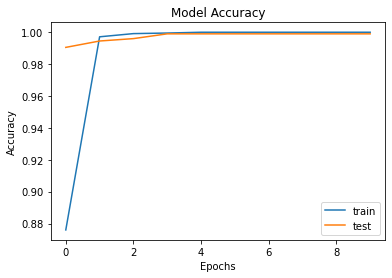

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [33]:
results = model.predict(x_val)
results = np.argmax(results,axis=1)
results

125/125 [==============================] - 7s 58ms/step


array([2, 8, 4, ..., 1, 0, 1], dtype=int64)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
score = 0
for i in range(len(results)):
    if results[i] == y_val[0][i]:
        score+=1

print(f"Test accurayc: {(score*100)/40000}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()